In [1]:
import os
import random
import itertools
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import VGG16, VGG19, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input as process_vgg16
from tensorflow.keras.applications.vgg19 import preprocess_input as process_vgg19
from tensorflow.keras.applications.resnet50 import preprocess_input as process_resnet

import cv2

from sklearn.metrics import classification_report, confusion_matrix

In [2]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [3]:
### DEFINE SOME PARAMETERS ###

base_path = "../input/split-garbage-dataset/split-garbage-dataset/"
labels = os.listdir(base_path + "train/")
SHAPE = (224,224,3)

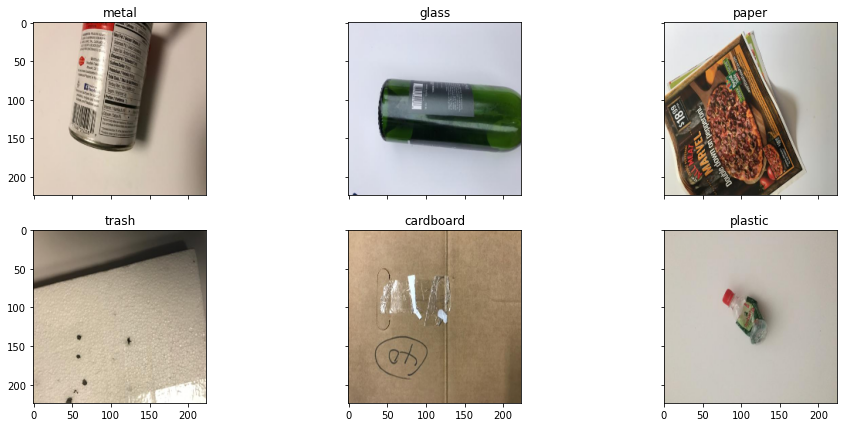

In [4]:
### PLOT SAMPLE IMAGES ###

f, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize = (16,7))

for ax, label in zip(axes.ravel(), labels):
    img = np.random.choice(os.listdir(base_path + "train/" + label))
    img = cv2.imread(base_path + "train/" + label + "/" + img)
    img = cv2.resize(img, SHAPE[:2])
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGRA2RGB))
    ax.set_title(label)

In [5]:
### CREATE EMPTY GENERATORS ###

train_datagen = ImageDataGenerator(
        rotation_range = 20,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        horizontal_flip = True,
        vertical_flip = True,
        fill_mode='nearest'
)

validation_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

In [6]:
### FLOW GENERATORS ###

train_batch_size = 32
val_batch_size = 32

train_generator = train_datagen.flow_from_directory(
            base_path + '/train',
            target_size = (SHAPE[0], SHAPE[1]),
            batch_size = train_batch_size,
            class_mode = 'categorical',
            shuffle = True
)

validation_generator = validation_datagen.flow_from_directory(
            base_path + '/valid',
            target_size = (SHAPE[0], SHAPE[1]),
            batch_size = val_batch_size,
            class_mode = 'categorical',
            shuffle = False
)

test_generator = test_datagen.flow_from_directory(
            base_path + '/test',
            target_size = (SHAPE[0], SHAPE[1]),
            batch_size = val_batch_size,
            class_mode = 'categorical',
            shuffle = False
)

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.


In [7]:
### RETRIVE TEST LABEL FROM GENERATOR ###

test_num = test_generator.samples

label_test = []
for i in range((test_num // test_generator.batch_size)+1):
    X,y = test_generator.next()
    label_test.append(y)
        
label_test = np.argmax(np.vstack(label_test), axis=1)

label_test.shape

(431,)

In [8]:
def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

def import_base_model(SHAPE):

    vgg16 = VGG16(weights = 'imagenet', include_top = False, input_shape = SHAPE)
    vgg19 = VGG19(weights = 'imagenet', include_top = False, input_shape = SHAPE)
    resnet = ResNet50(weights = 'imagenet', include_top = False, input_shape = SHAPE)

    for layer in vgg16.layers[:-4]:
        layer.trainable = False

    for layer in vgg19.layers[:-5]:
        layer.trainable = False

    for layer in resnet.layers[:-10]:
        layer.trainable = False
        
    return vgg16, vgg19, resnet

# CONCATENATION

In [9]:
### GET PRETRAINED MODELS ###

vgg16, vgg19, resnet = import_base_model(SHAPE)

94773248/94765736 [==============================] - 1s 0us/step


In [10]:
set_seed(33)

inp = Input((224,224,3))

vgg_16_process = Lambda(process_vgg16)(inp)
vgg_16 = vgg16(vgg_16_process)
x_vgg_16 = GlobalMaxPool2D()(vgg_16)
x_vgg_16 = Dense(128, activation='relu')(x_vgg_16)

resnet_process = Lambda(process_resnet)(inp)
res_net = resnet(resnet_process)
x_resnet = GlobalMaxPool2D()(res_net)
x_resnet = Dense(128, activation='relu')(x_resnet)

vgg_19_process = Lambda(process_vgg19)(inp)
vgg_19 = vgg19(vgg_19_process)
x_vgg_19 = GlobalMaxPool2D()(vgg_19)
x_vgg_19 = Dense(128, activation='relu')(x_vgg_19)

x = Concatenate()([x_vgg_16, x_resnet, x_vgg_19])
out = Dense(6, activation='softmax')(x)

model = Model(inp, out)
model.compile(loss='categorical_crossentropy', optimizer=Nadam(lr=1e-4), metrics='accuracy')

es = EarlyStopping(monitor='val_accuracy', mode='auto', restore_best_weights=True, verbose=1, patience=7)
model.fit(train_generator, steps_per_epoch = train_generator.samples/train_generator.batch_size,
          epochs=50, validation_data=validation_generator, validation_steps = validation_generator.samples/validation_generator.batch_size, 
          callbacks=[es], verbose = 1)

Epoch 1/50
56/55 [==============================] - 53s 947ms/step - loss: 3.8443 - accuracy: 0.5730 - val_loss: 1.1178 - val_accuracy: 0.7409
Epoch 2/50
56/55 [==============================] - 36s 639ms/step - loss: 0.7241 - accuracy: 0.7986 - val_loss: 0.6174 - val_accuracy: 0.8415
Epoch 3/50
56/55 [==============================] - 36s 638ms/step - loss: 0.5227 - accuracy: 0.8462 - val_loss: 0.6217 - val_accuracy: 0.8445
Epoch 4/50
56/55 [==============================] - 36s 649ms/step - loss: 0.3705 - accuracy: 0.8914 - val_loss: 0.5366 - val_accuracy: 0.8598
Epoch 5/50
56/55 [==============================] - 36s 638ms/step - loss: 0.2587 - accuracy: 0.9270 - val_loss: 0.5342 - val_accuracy: 0.8720
Epoch 6/50
56/55 [==============================] - 35s 633ms/step - loss: 0.1862 - accuracy: 0.9316 - val_loss: 0.4376 - val_accuracy: 0.8872
Epoch 7/50
56/55 [==============================] - 35s 633ms/step - loss: 0.1693 - accuracy: 0.9423 - val_loss: 0.5065 - val_accuracy: 0.8780

In [11]:
pred_test = np.argmax(model.predict(test_generator), axis=1)

In [12]:
print(classification_report(label_test, pred_test, target_names=labels))

              precision    recall  f1-score   support

       metal       0.97      0.90      0.93        70
       glass       0.90      0.93      0.92        82
       paper       0.84      0.91      0.87        68
       trash       0.86      0.92      0.89       108
   cardboard       0.86      0.84      0.85        74
     plastic       0.90      0.66      0.76        29

    accuracy                           0.88       431
   macro avg       0.89      0.86      0.87       431
weighted avg       0.89      0.88      0.88       431



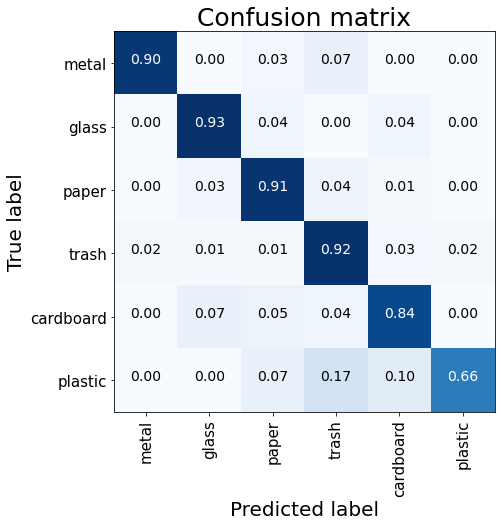

In [13]:
cnf_matrix = confusion_matrix(label_test, pred_test)

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=labels)
plt.show()

# SIMPLE AVERAGE

In [14]:
### GET PRETRAINED MODELS ###

vgg16, vgg19, resnet = import_base_model(SHAPE)

In [15]:
set_seed(33)

inp = Input((224,224,3))

vgg_16_process = Lambda(process_vgg16)(inp)
vgg_16 = vgg16(vgg_16_process)
x_vgg_16 = GlobalMaxPool2D()(vgg_16)
x_vgg_16 = Dense(128, activation='relu')(x_vgg_16)

resnet_process = Lambda(process_resnet)(inp)
res_net = resnet(resnet_process)
x_resnet = GlobalMaxPool2D()(res_net)
x_resnet = Dense(128, activation='relu')(x_resnet)

vgg_19_process = Lambda(process_vgg19)(inp)
vgg_19 = vgg19(vgg_19_process)
x_vgg_19 = GlobalMaxPool2D()(vgg_19)
x_vgg_19 = Dense(128, activation='relu')(x_vgg_19)

x = Average()([x_vgg_16, x_resnet, x_vgg_19])
out = Dense(6, activation='softmax')(x)

model = Model(inp, out)
model.compile(loss='categorical_crossentropy', optimizer=Nadam(lr=1e-4), metrics='accuracy')

es = EarlyStopping(monitor='val_accuracy', mode='auto', restore_best_weights=True, verbose=1, patience=7)
model.fit(train_generator, steps_per_epoch = train_generator.samples/train_generator.batch_size,
          epochs=50, validation_data=validation_generator, validation_steps = validation_generator.samples/validation_generator.batch_size, 
          callbacks=[es], verbose = 1)

Epoch 1/50
56/55 [==============================] - 37s 667ms/step - loss: 2.4407 - accuracy: 0.6210 - val_loss: 0.5574 - val_accuracy: 0.8201
Epoch 2/50
56/55 [==============================] - 35s 632ms/step - loss: 0.5838 - accuracy: 0.8150 - val_loss: 0.5557 - val_accuracy: 0.8384
Epoch 3/50
56/55 [==============================] - 36s 637ms/step - loss: 0.3661 - accuracy: 0.8807 - val_loss: 0.4796 - val_accuracy: 0.8750
Epoch 4/50
56/55 [==============================] - 36s 643ms/step - loss: 0.2737 - accuracy: 0.9123 - val_loss: 0.5218 - val_accuracy: 0.8506
Epoch 5/50
56/55 [==============================] - 36s 640ms/step - loss: 0.2003 - accuracy: 0.9367 - val_loss: 0.4729 - val_accuracy: 0.8811
Epoch 6/50
56/55 [==============================] - 36s 640ms/step - loss: 0.1430 - accuracy: 0.9502 - val_loss: 0.4815 - val_accuracy: 0.8750
Epoch 7/50
56/55 [==============================] - 36s 640ms/step - loss: 0.1333 - accuracy: 0.9581 - val_loss: 0.5447 - val_accuracy: 0.8902

In [16]:
pred_test = np.argmax(model.predict(test_generator), axis=1)

In [17]:
print(classification_report(label_test, pred_test, target_names=labels))

              precision    recall  f1-score   support

       metal       0.93      0.89      0.91        70
       glass       0.97      0.88      0.92        82
       paper       0.81      0.94      0.87        68
       trash       0.90      0.89      0.89       108
   cardboard       0.83      0.88      0.86        74
     plastic       0.88      0.79      0.84        29

    accuracy                           0.89       431
   macro avg       0.89      0.88      0.88       431
weighted avg       0.89      0.89      0.89       431



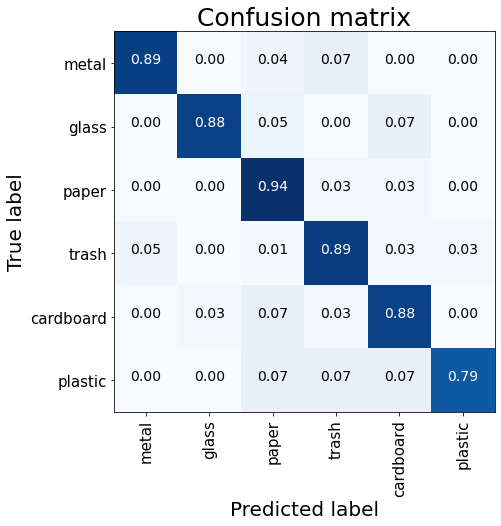

In [18]:
cnf_matrix = confusion_matrix(label_test, pred_test)

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=labels)
plt.show()

# WEIGHTED AVERAGE

In [19]:
### GET PRETRAINED MODELS ###

vgg16, vgg19, resnet = import_base_model(SHAPE)

In [20]:
class LinearW(Layer):

    def __init__(self):
        super(LinearW, self).__init__()
        
    def build(self, input_shape):
        
        self.W = self.add_weight(
                    shape=(1,1,len(input_shape)),
                    initializer='uniform',
                    dtype=tf.float32,
                    trainable=True)
        
    def call(self, inputs):

        # inputs is a list of tensor of shape [(n_batch, n_feat), ..., (n_batch, n_feat)]
        # expand last dim of each input passed [(n_batch, n_feat, 1), ..., (n_batch, n_feat, 1)]
        inputs = [tf.expand_dims(i, -1) for i in inputs]
        inputs = Concatenate(axis=-1)(inputs) # (n_batch, n_feat, n_inputs)
        weights = tf.nn.softmax(self.W, axis=-1) # (1,1,n_inputs)
        # weights sum up to one on last dim

        return tf.reduce_sum(weights*inputs, axis=-1) # (n_batch, n_feat)

In [21]:
set_seed(33)

inp = Input((224,224,3))

vgg_16_process = Lambda(process_vgg16)(inp)
vgg_16 = vgg16(vgg_16_process)
x_vgg_16 = GlobalMaxPool2D()(vgg_16)
x_vgg_16 = Dense(128, activation='relu')(x_vgg_16)

resnet_process = Lambda(process_resnet)(inp)
res_net = resnet(resnet_process)
x_resnet = GlobalMaxPool2D()(res_net)
x_resnet = Dense(128, activation='relu')(x_resnet)

vgg_19_process = Lambda(process_vgg19)(inp)
vgg_19 = vgg19(vgg_19_process)
x_vgg_19 = GlobalMaxPool2D()(vgg_19)
x_vgg_19 = Dense(128, activation='relu')(x_vgg_19)

x = LinearW()([x_vgg_16, x_resnet, x_vgg_19])
out = Dense(6, activation='softmax')(x)

model = Model(inp, out)
model.compile(loss='categorical_crossentropy', optimizer=Nadam(lr=1e-4), metrics='accuracy')

es = EarlyStopping(monitor='val_accuracy', mode='auto', restore_best_weights=True, verbose=1, patience=7)
model.fit(train_generator, steps_per_epoch = train_generator.samples/train_generator.batch_size,
          epochs=50, validation_data=validation_generator, validation_steps = validation_generator.samples/validation_generator.batch_size, 
          callbacks=[es], verbose = 1)

Epoch 1/50
56/55 [==============================] - 37s 660ms/step - loss: 2.5170 - accuracy: 0.6001 - val_loss: 0.6551 - val_accuracy: 0.7805
Epoch 2/50
56/55 [==============================] - 36s 638ms/step - loss: 0.6010 - accuracy: 0.8077 - val_loss: 0.6298 - val_accuracy: 0.8262
Epoch 3/50
56/55 [==============================] - 36s 636ms/step - loss: 0.3627 - accuracy: 0.8818 - val_loss: 0.5722 - val_accuracy: 0.8171
Epoch 4/50
56/55 [==============================] - 36s 644ms/step - loss: 0.2814 - accuracy: 0.9112 - val_loss: 0.4821 - val_accuracy: 0.8476
Epoch 5/50
56/55 [==============================] - 36s 645ms/step - loss: 0.2204 - accuracy: 0.9225 - val_loss: 0.5557 - val_accuracy: 0.8567
Epoch 6/50
56/55 [==============================] - 36s 635ms/step - loss: 0.1727 - accuracy: 0.9457 - val_loss: 0.5702 - val_accuracy: 0.8598
Epoch 7/50
56/55 [==============================] - 36s 636ms/step - loss: 0.1202 - accuracy: 0.9576 - val_loss: 0.4754 - val_accuracy: 0.8750

In [22]:
### RETRIVE LINEAR WEIGHTS ###

tf.nn.softmax(model.get_weights()[-3]).numpy()

array([[[0.34190792, 0.32223913, 0.335853  ]]], dtype=float32)

In [23]:
pred_test = np.argmax(model.predict(test_generator), axis=1)

In [24]:
print(classification_report(label_test, pred_test, target_names=labels))

              precision    recall  f1-score   support

       metal       0.97      0.91      0.94        70
       glass       0.94      0.82      0.88        82
       paper       0.94      0.91      0.93        68
       trash       0.87      0.97      0.92       108
   cardboard       0.82      0.88      0.85        74
     plastic       0.86      0.83      0.84        29

    accuracy                           0.90       431
   macro avg       0.90      0.89      0.89       431
weighted avg       0.90      0.90      0.90       431



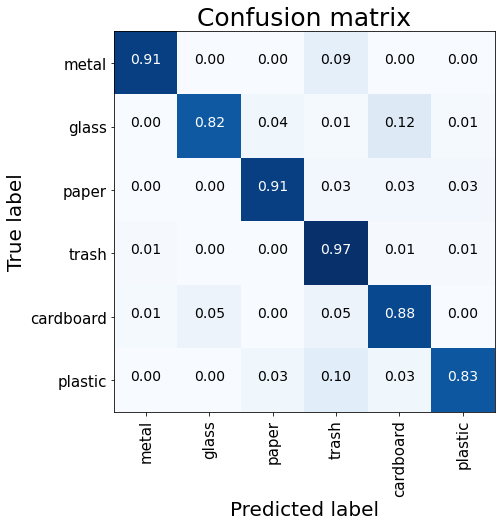

In [25]:
cnf_matrix = confusion_matrix(label_test, pred_test)

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=labels)
plt.show()